# **U-Net 모델 구현**

✅ 아래 코드는 PyTorch로 작성한 간단한 U-Net 모델입니다.

✅ 주요 목표: 작은 이미지 세트로 segmentation 학습을 테스트하기!

✅ 특징: 업샘플링(deconv/upsample 선택 가능), 입력 스케일링, Gaussian noise 추가, 배치 정규화 적용

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# --- 작은 U-Net 정의 ---
class UNetSmall(nn.Module):
    def __init__(self, upsample_mode='deconv', net_scaling=None, edge_crop=0, gaussian_noise_std=0.1):
        super().__init__()
        self.net_scaling = net_scaling
        self.edge_crop = edge_crop
        self.gaussian_noise_std = gaussian_noise_std
        self.upsample_mode = upsample_mode

         # Convolution Block: Conv -> ReLU -> Conv -> ReLU
        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        # 인코더 부분 목표 -> 128 까지!
        self.enc1 = conv_block(3, 32)
        self.enc2 = conv_block(32, 64)
        self.enc3 = conv_block(64, 96)
        self.enc4 = conv_block(96, 128)
        # Bottleneck
        self.center = conv_block(128, 128)
        self.pool = nn.MaxPool2d(2)


        # 업샘플링 부분 정의 (deconv 또는 upsample+conv) 로
        if upsample_mode == 'deconv':
            def upsample_layer(in_c, out_c):
                return nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2)
        else:
            def upsample_layer(in_c, out_c):
                return nn.Sequential(
                    nn.Upsample(scale_factor=2, mode='nearest'),
                    nn.Conv2d(in_c, out_c, 1)
                )
        # 디코더 부분
        self.up4 = upsample_layer(128, 96)
        self.dec4 = conv_block(96+128, 96)
        self.up3 = upsample_layer(96, 64)
        self.dec3 = conv_block(64+96, 64)
        self.up2 = upsample_layer(64, 32)
        self.dec2 = conv_block(32+64, 32)
        self.up1 = upsample_layer(32, 16)
        self.dec1 = conv_block(16+32, 16)

        # 최종 출력: 1채널(segmentation mask)
        self.final = nn.Conv2d(16, 1, kernel_size=1)

    def forward(self, x):
        if self.net_scaling:
        # 입력 스케일링
            x = F.avg_pool2d(x, self.net_scaling)
        # Gaussian noise 추가
        if self.gaussian_noise_std:
            noise = torch.randn_like(x) * self.gaussian_noise_std
            x = x + noise

        # 배치 정규화 적용
        x = F.batch_norm(x, running_mean=None, running_var=None, training=True)

        # 인코더
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        # Bottleneck
        center = self.center(self.pool(e4))

        # 디코더 + Skip Connection
        d4 = self.up4(center)
        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.dec4(d4)

        d3 = self.up3(d4)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat([d2,e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        out = self.final(d1)
        out = torch.sigmoid(out)
         # Crop + Pad
        if self.edge_crop > 0:
            out = out[:, :, self.edge_crop:-self.edge_crop, self.edge_crop:-self.edge_crop]
            out = F.pad(out, (self.edge_crop, self.edge_crop, self.edge_crop, self.edge_crop))
        # Upsample 다시 확대
        if self.net_scaling:
            out = F.interpolate(out, scale_factor=self.net_scaling, mode='nearest')

        return out


## **학습용 데이터 생성하기**

In [11]:
batch_size = 32
x = torch.randn(batch_size, 3, 128, 128)  # RGB 이미지
y = (torch.rand(batch_size, 1, 128, 128) > 0.5).float()  # 랜덤 이진 마스크

dataset = TensorDataset(x, y)
loader = DataLoader(dataset, batch_size=2, shuffle=True)

## **데이터 시각화**

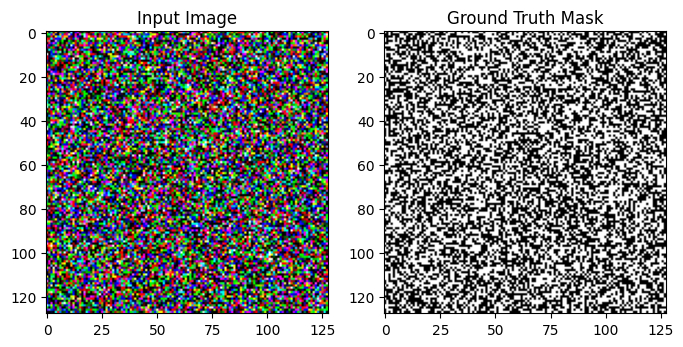

In [12]:
import matplotlib.pyplot as plt
# 첫 번째 이미지를 시각화
sample_x = x[0]
sample_y = y[0]

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(sample_x.permute(1, 2, 0).numpy())
plt.title('Input Image')

plt.subplot(1, 2, 2)
plt.imshow(sample_y.squeeze().numpy(), cmap='gray')
plt.title('Ground Truth Mask')
plt.show()

## **모델 선언 및 학습**

In [13]:
# --- 모델 선언 및 학습 ---
model = UNetSmall(upsample_mode='deconv', net_scaling=None, edge_crop=0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()

# 간단히 30 epoch만
for epoch in range(10):
    model.train()
    total_loss = 0
    for xb, yb in loader:
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(loader):.4f}")

Epoch 1, Loss: 0.6938
Epoch 2, Loss: 0.6932
Epoch 3, Loss: 0.6932
Epoch 4, Loss: 0.6932
Epoch 5, Loss: 0.6931
Epoch 6, Loss: 0.6930
Epoch 7, Loss: 0.6930
Epoch 8, Loss: 0.6929
Epoch 9, Loss: 0.6928
Epoch 10, Loss: 0.6926


## **아래 주석을 풀고 U-Net 모델에 대해 간단히 설명해주세요 😀**

[답변]


---
U자형 인코더-디코더 구조와 스킵 연결을 활용하여, 이미지의 의미를 파악하면서도 세부적인 위치 정보를 보존하는 강력한 이미지 분할 모델


## **아래 주석을 풀고 DeepLabv1, v2, v3. v3+  모델에 대해 각각 간단히 설명해주세요 🐶**

[답변]


---

[DeepLab v1] 해상도를 유지하기 위해 Atrous Convolution을 도입 / CRF를 적용한 초기 모델

[DeepLab v2] 다양한 객체 크기를 처리하기 위해 Atrous Spatial Pyramid Pooling(ASPP)을 도입 / CRF 후처리를 유지

[DeepLab v3] 복잡한 CRF 후처리를 제거하여 효율성을 높인 모델

[DeepLab v3+] 인코더-디코더 구조와 경량화된 Depthwise Convolution을 통해 경계 복원 성능과 연산 효율을 모두 개선